<a href="https://colab.research.google.com/github/Yomex139/Beans_dataset-project/blob/main/Beans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# importing libraries

In [1]:
#beans dataset
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
#downloading helper function
!wget https://github.com/Yomex139/Food-Vision/raw/main/Helper_Function.py

from Helper_Function import load_and_prep_image,walk_through_dir,compare_historys,confusion_matrix,create_tensorboard_callback,plot_loss_curves,visual_tf_dataset,visualize_processed_data

--2021-10-21 23:10:10--  https://github.com/Yomex139/Food-Vision/raw/main/Helper_Function.py
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Yomex139/Food-Vision/main/Helper_Function.py [following]
--2021-10-21 23:10:10--  https://raw.githubusercontent.com/Yomex139/Food-Vision/main/Helper_Function.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13103 (13K) [text/plain]
Saving to: ‘Helper_Function.py.1’

Helper_Function.py. 100%[===================>]  12.80K  --.-KB/s    in 0s      

2021-10-21 23:10:10 (88.9 MB/s) - ‘Helper_Function.py.1’ saved [13103/13103]



#downloading dataset(Beans) from tensorflow dataset catalogue

In [3]:
#download from tensorflow dataset
(test,train,validation),ds_info = tfds.load(name='beans',
                                            shuffle_files=True,
                                            as_supervised=True,
                                            split=['test','train','validation'],
                                            with_info=True
                                            )

In [4]:
ds_info.description

'Beans is a dataset of images of beans taken in the field using smartphone\ncameras. It consists of 3 classes: 2 disease classes and the healthy class.\nDiseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated\nby experts from the National Crops Resources Research Institute (NaCRRI) in\nUganda and collected by the Makerere AI research lab.'

In [5]:
len(test),len(train),len(validation)

(128, 1034, 133)

In [6]:
class_name = ds_info.features['label'].names
class_name

['angular_leaf_spot', 'bean_rust', 'healthy']

# visualize visualize visualize!!!!!!!!!!!

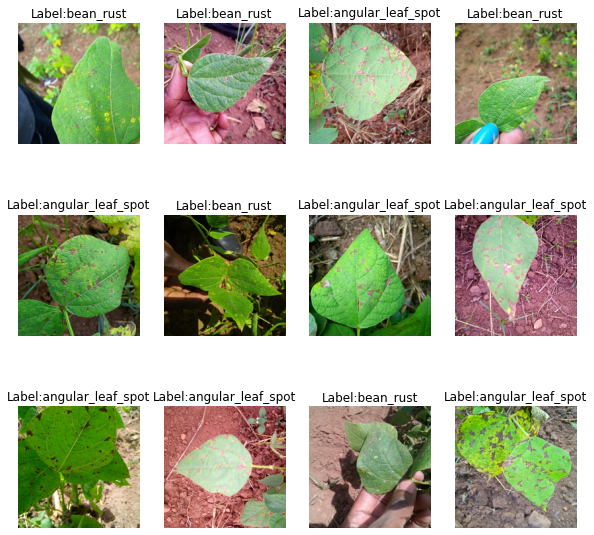

In [7]:
#visualizing train dataset
visual_tf_dataset(data=train,
                  class_name = class_name)

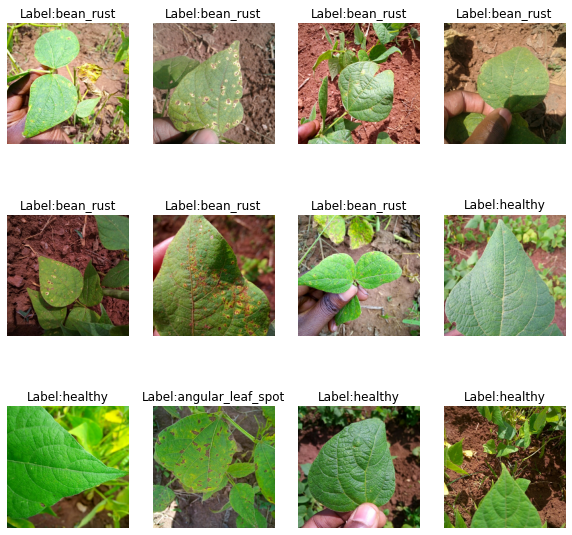

In [8]:
#visualizing validation dataset
visual_tf_dataset(data=validation,
                  class_name = class_name)

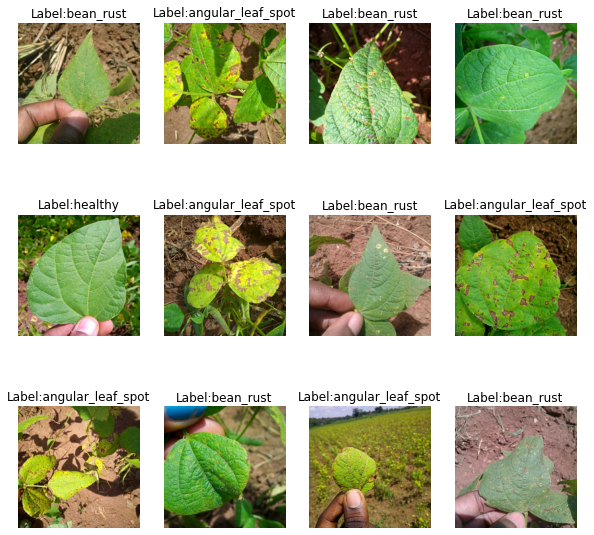

In [9]:
#visualizing test dataset
visual_tf_dataset(data=test,
                  class_name=class_name)

# set up callbacks

In [10]:
#early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3)
#model checkpoint callback
beans_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='Beans/model_checkpoint/cp.ckpt',
                                                            save_best_only=True,
                                                            save_weights_only=True)

# Data Prerocessing

In [11]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes image to
  [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
  image = tf.image.convert_image_dtype(image,dtype=tf.float32) # convert to float 32
  return image,label 

#map preprocess functions to all dataset(train,validation,test) 
##mapping function to train data
train_data = train.map(preprocess_img,num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=len(train)).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
##mapping function to validation data
valid_data = validation.map(map_func=preprocess_img,num_parallel_calls=tf.data.AUTOTUNE)
valid_data = valid_data.shuffle(buffer_size=len(validation)).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
##mapping function to test data
test_data = test.map(map_func=preprocess_img,num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)


size after preprocessed is (224, 224, 3)


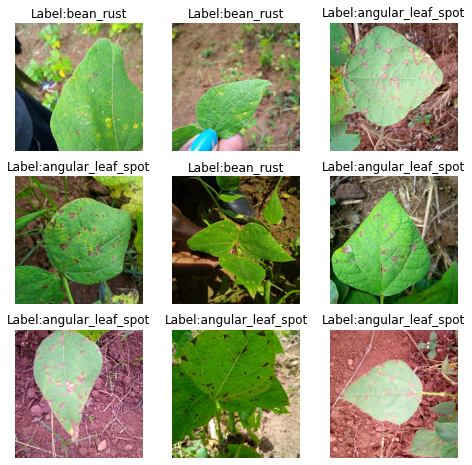

In [12]:
visualize_processed_data(data=train,class_name=class_name)

In [13]:
#set up mixed_precision for faster computation
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('float16')

# Create the model

In [14]:
#set up base model
Base_model = tf.keras.applications.EfficientNetB0(include_top=False)
#settrainability to false
Base_model.trainable=False
#set up input
input = tf.keras.layers.Input(shape=(224,224,3),name='Input_layer')
#map Base model to input
x = Base_model(input,training=False)
#GlobalAveragePooling
x = tf.keras.layers.GlobalAveragePooling2D(name='GlobalAveragePooling')(x)
#dense layer
x = tf.keras.layers.Dense(3)(x)
#activation layer
output = tf.keras.layers.Activation(activation='softmax',dtype=tf.float32,name='activation')(x)
model_1 = tf.keras.Model(input,output)

In [15]:
#compile the moddel
model_1.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [19]:
#model summary
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
GlobalAveragePooling (Global (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
_________________________________________________________________
activation (Activation)      (None, 3)                 0         
Total params: 4,053,414
Trainable params: 3,843
Non-trainable params: 4,049,571
_________________________________________________________________


In [16]:
#fit the model
history_1 = model_1.fit(train_data,
                        validation_data = valid_data,
                        epochs=25,
                        steps_per_epoch=len(train_data),
                        validation_steps=len(valid_data),
                        callbacks=[early_stop,beans_model_checkpoint,create_tensorboard_callback(dir_name='Beans_dataset',
                                                                                                experiment_name='beans dataset modelling with EfficientNetB0')])

Saving TensorBoard log files to: Beans_dataset/beans dataset modelling with EfficientNetB0/20211021-231020
Epoch 1/25


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


33/33 [==============================] - 38s 625ms/step - loss: 1.7061 - accuracy: 0.4739 - val_loss: 1.4414 - val_accuracy: 0.5039
Epoch 2/25
33/33 [==============================] - 6s 114ms/step - loss: 1.1914 - accuracy: 0.5957 - val_loss: 1.1846 - val_accuracy: 0.6089
Epoch 3/25
33/33 [==============================] - 6s 114ms/step - loss: 0.9941 - accuracy: 0.6528 - val_loss: 1.0527 - val_accuracy: 0.6689
Epoch 4/25
33/33 [==============================] - 6s 113ms/step - loss: 0.8701 - accuracy: 0.6973 - val_loss: 0.9561 - val_accuracy: 0.7217
Epoch 5/25
33/33 [==============================] - 6s 112ms/step - loss: 0.7690 - accuracy: 0.7188 - val_loss: 0.8770 - val_accuracy: 0.7441
Epoch 6/25
33/33 [==============================] - 6s 118ms/step - loss: 0.6909 - accuracy: 0.7466 - val_loss: 0.8208 - val_accuracy: 0.7368
Epoch 7/25
33/33 [==============================] - 6s 112ms/step - loss: 0.6250 - accuracy: 0.7773 - val_loss: 0.7705 - val_accuracy: 0.7896
Epoch 8/25
33/33

In [18]:
test_score = model_1.evaluate(test_data)
test_score

4/4 [==============================] - 1s 110ms/step - loss: 0.3687 - accuracy: 0.8516


[0.36865234375, 0.8515625]

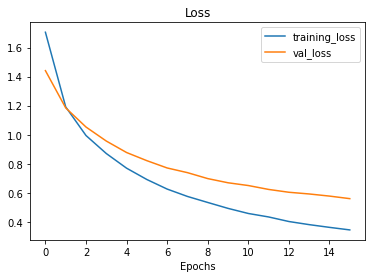

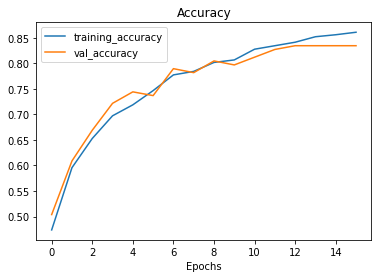

In [20]:
#plot history curve
plot_loss_curves(history_1)

# building data augmentation right into the model

In [22]:
#model checkpoint callback
beans_model_checkpoint_aug = tf.keras.callbacks.ModelCheckpoint(filepath='Beans/model_checkpoint_aug/cp.ckpt',
                                                            save_best_only=True,
                                                            save_weights_only=True)
#data augmentation create using sequencial model
data_augmentaton = tf.keras.models.Sequential([
            tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
            tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
            tf.keras.layers.experimental.preprocessing.RandomWidth(.15),
            tf.keras.layers.experimental.preprocessing.RandomContrast(.4)
],name='augmentation_layer')

#recreate model as model_1 but dis time around with data augmentation
##set trainability to False
Base_model.trainable=False
##input layer
input = tf.keras.layers.Input(shape=(224,224,3))
#aumentation layer
x = data_augmentaton(input)
#Base_model
x = Base_model(x,training=False)
#GlobalAveragePooling layer
x = tf.keras.layers.GlobalAveragePooling2D(name='GlobalAveragePooling_layer')(x)
#Dense layer
x = tf.keras.layers.Dense(3,name='Dense_layer')(x)
#activation layer
output = tf.keras.layers.Activation(activation='softmax',dtype=tf.float32,name='Activation_layer')(x)
#build the model
model_2 = tf.keras.Model(input,output)

#compile the model
model_2.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

#fit the model
history_2 = model_2.fit(train_data,
                        validation_data = valid_data,
                        epochs=25,
                        steps_per_epoch=len(train_data),
                        validation_steps=len(valid_data),
                        callbacks=[early_stop,beans_model_checkpoint_aug,create_tensorboard_callback(dir_name='Beans_dataset',
                                                                                                experiment_name='beans dataset with data_augmentation modelling with EfficientNetB0')])

Saving TensorBoard log files to: Beans_dataset/beans dataset with data_augmentation modelling with EfficientNetB0/20211021-233811
Epoch 1/25


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


33/33 [==============================] - 180s 5s/step - loss: 2.9980 - accuracy: 0.3694 - val_loss: 1.8320 - val_accuracy: 0.4211
Epoch 2/25
33/33 [==============================] - 63s 2s/step - loss: 1.7832 - accuracy: 0.4265 - val_loss: 1.2432 - val_accuracy: 0.5186
Epoch 3/25
33/33 [==============================] - 53s 2s/step - loss: 1.1953 - accuracy: 0.5659 - val_loss: 1.0049 - val_accuracy: 0.6089
Epoch 4/25
33/33 [==============================] - 49s 1s/step - loss: 0.9268 - accuracy: 0.6323 - val_loss: 0.9390 - val_accuracy: 0.6841
Epoch 5/25
33/33 [==============================] - 40s 1s/step - loss: 0.8491 - accuracy: 0.6816 - val_loss: 0.8867 - val_accuracy: 0.7217
Epoch 6/25
33/33 [==============================] - 44s 1s/step - loss: 0.7432 - accuracy: 0.7227 - val_loss: 0.8408 - val_accuracy: 0.7295
Epoch 7/25
33/33 [==============================] - 50s 1s/step - loss: 0.7153 - accuracy: 0.7280 - val_loss: 0.8179 - val_accuracy: 0.7217
Epoch 8/25
33/33 [============

In [23]:
#evaluate model_2 on test data
test_aug_score = model_2.evaluate(test_data)
test_aug_score

4/4 [==============================] - 1s 122ms/step - loss: 0.4956 - accuracy: 0.8125


[0.49560546875, 0.8125]

In [24]:
#summary of model_2
model_2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
augmentation_layer (Sequenti (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
GlobalAveragePooling_layer ( (None, 1280)              0         
_________________________________________________________________
Dense_layer (Dense)          (None, 3)                 3843      
_________________________________________________________________
Activation_layer (Activation (None, 3)                 0         
Total params: 4,053,414
Trainable params: 3,843
Non-trainable params: 4,049,571
_____________________________________________

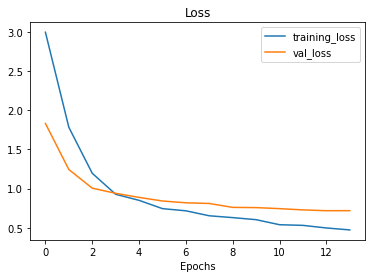

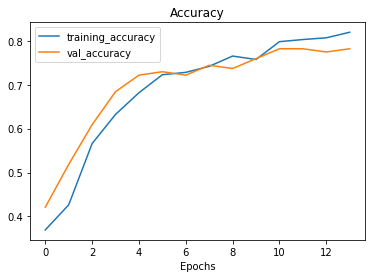

In [25]:
plot_loss_curves(history_2)

# fine-tune the base model(Base_model)

In [26]:
#checking for trainability in model_1
for layer_num,layers in enumerate(model_1.layers):
  print(layer_num,layers.name,layers.trainable)

0 Input_layer True
1 efficientnetb0 False
2 GlobalAveragePooling True
3 dense True
4 activation True


In [29]:
#result shows the base model is untrainable so set the trainability to True
##unfreeze all layers in base model
Base_model.trainable=True

In [30]:
#check for trainability in the base model
for layer_num,layers in enumerate(model_1.layers[1].layers):
  print(layer_num,layers.name,layers.trainable)

0 input_1 True
1 rescaling True
2 normalization True
3 stem_conv_pad True
4 stem_conv True
5 stem_bn True
6 stem_activation True
7 block1a_dwconv True
8 block1a_bn True
9 block1a_activation True
10 block1a_se_squeeze True
11 block1a_se_reshape True
12 block1a_se_reduce True
13 block1a_se_expand True
14 block1a_se_excite True
15 block1a_project_conv True
16 block1a_project_bn True
17 block2a_expand_conv True
18 block2a_expand_bn True
19 block2a_expand_activation True
20 block2a_dwconv_pad True
21 block2a_dwconv True
22 block2a_bn True
23 block2a_activation True
24 block2a_se_squeeze True
25 block2a_se_reshape True
26 block2a_se_reduce True
27 block2a_se_expand True
28 block2a_se_excite True
29 block2a_project_conv True
30 block2a_project_bn True
31 block2b_expand_conv True
32 block2b_expand_bn True
33 block2b_expand_activation True
34 block2b_dwconv True
35 block2b_bn True
36 block2b_activation True
37 block2b_se_squeeze True
38 block2b_se_reshape True
39 block2b_se_reduce True
40 block

In [31]:
#refreeze the base model except the last eight(8) layers
for layer_num,layers in enumerate(Base_model.layers[:-8]):
  layers.trainable=False

In [32]:
#check for trainability in the base model after trefreezing
for layer_num,layers in enumerate(model_1.layers[1].layers):
  print(layer_num,layers.name,layers.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [37]:
#recompile the model
model_1.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(learning_rate=.0001),
                metrics=['accuracy'])

In [41]:
#model checkpoint callback
beans_model_checkpoint_fine_tune = tf.keras.callbacks.ModelCheckpoint(filepath='Beans/model_checkpoint_fine_tune/cp.ckpt',
                                                            save_best_only=True,
                                                            save_weights_only=True)

init_epoch=16
finetune_epoch = init_epoch*2
#fit the model
history_3 = model_1.fit(train_data,
                        validation_data = valid_data,
                        epochs=finetune_epoch,
                        initial_epoch=init_epoch,
                        steps_per_epoch=len(train_data),
                        validation_steps=len(valid_data),
                        callbacks=[early_stop,beans_model_checkpoint_fine_tune,create_tensorboard_callback(dir_name='Beans_dataset',
                                                                                                experiment_name='beans dataset with fine_tuning modelling with EfficientNetB0')])

Saving TensorBoard log files to: Beans_dataset/beans dataset with fine_tuning modelling with EfficientNetB0/20211022-003235
Epoch 17/32


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


33/33 [==============================] - 17s 210ms/step - loss: 0.3252 - accuracy: 0.8770 - val_loss: 0.4624 - val_accuracy: 0.8647
Epoch 18/32
33/33 [==============================] - 7s 124ms/step - loss: 0.1758 - accuracy: 0.9263 - val_loss: 0.5210 - val_accuracy: 0.8721
Epoch 19/32
33/33 [==============================] - 7s 122ms/step - loss: 0.3264 - accuracy: 0.8828 - val_loss: 0.5903 - val_accuracy: 0.8799
Epoch 20/32
33/33 [==============================] - 7s 123ms/step - loss: 0.5679 - accuracy: 0.8560 - val_loss: 1.0400 - val_accuracy: 0.8647
Epoch 21/32
33/33 [==============================] - 7s 122ms/step - loss: 0.4216 - accuracy: 0.9062 - val_loss: 0.3230 - val_accuracy: 0.9097
Epoch 22/32
33/33 [==============================] - 7s 122ms/step - loss: 0.2585 - accuracy: 0.9380 - val_loss: 0.4136 - val_accuracy: 0.8945
Epoch 23/32
33/33 [==============================] - 7s 123ms/step - loss: 0.1127 - accuracy: 0.9673 - val_loss: 0.4204 - val_accuracy: 0.9175
Epoch 24/3

In [42]:
#evaluate fine_tune model on test dataset
fine_tune_model_score = model_1.evaluate(test_data)
fine_tune_model_score

4/4 [==============================] - 1s 120ms/step - loss: 0.2979 - accuracy: 0.9375


[0.2978515625, 0.9375]

In [43]:
#check model_1 fine tune summary
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
GlobalAveragePooling (Global (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
_________________________________________________________________
activation (Activation)      (None, 3)                 0         
Total params: 4,053,414
Trainable params: 897,075
Non-trainable params: 3,156,339
_________________________________________________________________


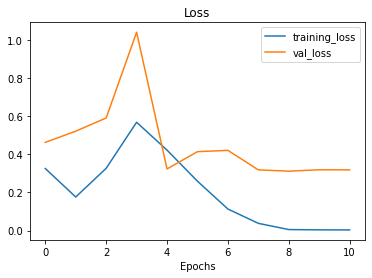

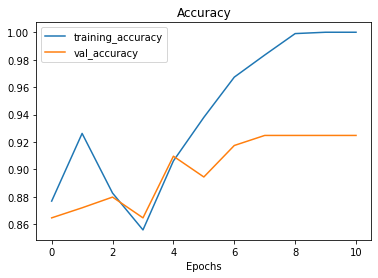

In [44]:
#plot loss curve
plot_loss_curves(history_3)

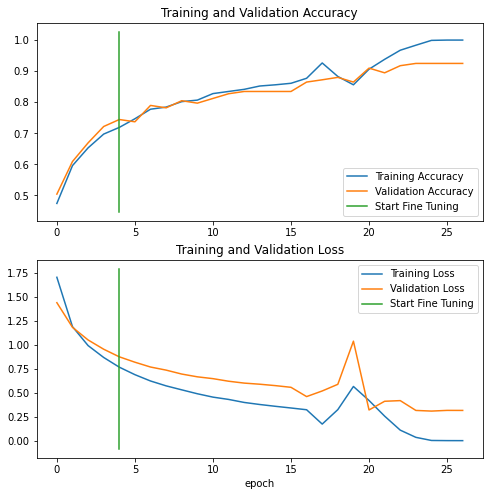

In [45]:
compare_historys(history_1,history_3)

'Beans is a dataset of images of beans taken in the field using smartphone\ncameras. It consists of 3 classes: 2 disease classes and the healthy class.\nDiseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated\nby experts from the National Crops Resources Research Institute (NaCRRI) in\nUganda and collected by the Makerere AI research lab.'

In [49]:
#upload tensorboard callback to google colab dev
!tensorboard dev upload --logdir ./Beans_dataset\
  --name 'expriment with Beans dataset'\
  --description 'Beans is a dataset of images of beans taken in the field using smartphone\ncameras. It consists of 3 classes: 2 disease classes and the healthy class...Training from https://github.com/Yomex139'\
  --one_shot

2021-10-22 00:53:09.483937: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-22 00:53:09.504251: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-22 00:53:09.505043: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./Beans_dataset

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy 

In [50]:
!tensorboard dev list

2021-10-22 00:58:02.841417: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-22 00:58:02.850884: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-22 00:58:02.851534: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
https://tensorboard.dev/experiment/y8MXoiPAQlKzWV1OnRGWag/
	Name                 expriment with Beans dataset
	Description          Beans is a dataset of images of beans taken in the field using smartphone\ncameras. It consists of 3 classes: 2 disease classes and the healthy class...Training from https://github.com/Yomex139
	Id           